In [1]:
# !pip install transformers
# !pip install nlpaug
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/gdrive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
import transformers
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from torch import nn
import torch.nn.functional as F
#from tqdm import trange
from tqdm.notebook import tqdm, trange
import os
from transformers import AdamW, get_linear_schedule_with_warmup
import nlpaug
from tcn import TemporalConvNet


cuda


In [2]:
PATH = 'C:/Users/Hardeep/Desktop/nlp_proj/'
set_user = 0
import sys
import os
print(PATH)
sys.path.append(os.path.abspath(PATH))
rev = pd.read_json(PATH + 'yelp_review_training_dataset.jsonl', lines=True)

delete_aug_data = pd.read_csv(PATH + 'augmentations/delete_aug.csv', header=None)
swap_aug_data = pd.read_csv(PATH + 'augmentations/swap_aug.csv', header=None)
typo_aug_data = pd.read_csv(PATH + 'augmentations/typo_aug.csv', header=None)
synoynm_aug_data = pd.read_csv(PATH + 'augmentations/synonym_aug.csv', header=None)

delete_aug_data.columns = delete_aug_data.iloc[0]
delete_aug_data = delete_aug_data[1:]
delete_aug_data['stars'] = delete_aug_data['stars'].astype('int64')

swap_aug_data.columns = swap_aug_data.iloc[0]
swap_aug_data = swap_aug_data[1:]
swap_aug_data['stars'] = swap_aug_data['stars'].astype('int64')

typo_aug_data.columns = typo_aug_data.iloc[0]
typo_aug_data = typo_aug_data[1:]
typo_aug_data['stars'] = typo_aug_data['stars'].astype('int64')

synoynm_aug_data.columns = synoynm_aug_data.iloc[0]
synoynm_aug_data = synoynm_aug_data[1:]
synoynm_aug_data['stars'] = synoynm_aug_data['stars'].astype('int64')

C:/Users/Hardeep/Desktop/nlp_proj/


C:\Users\Hardeep\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
del1 = delete_aug_data[delete_aug_data['stars'] == 1]
swap1 = swap_aug_data[swap_aug_data['stars'] == 1]
typo1 = typo_aug_data[typo_aug_data['stars'] == 1]
syn1 = synoynm_aug_data[synoynm_aug_data['stars'] == 1]

del2 = delete_aug_data[delete_aug_data['stars'] == 2]
swap2 = swap_aug_data[swap_aug_data['stars'] == 2]
typo2 = typo_aug_data[typo_aug_data['stars'] == 2]
syn2 = synoynm_aug_data[synoynm_aug_data['stars'] == 2]

del3 = delete_aug_data[delete_aug_data['stars'] == 3]
swap3 = swap_aug_data[swap_aug_data['stars'] == 3]
typo3 = typo_aug_data[typo_aug_data['stars'] == 3]
syn3 = synoynm_aug_data[synoynm_aug_data['stars'] == 3]

del4 = delete_aug_data[delete_aug_data['stars'] == 4]
swap4 = swap_aug_data[swap_aug_data['stars'] == 4]
typo4 = typo_aug_data[typo_aug_data['stars'] == 4]
syn4 = synoynm_aug_data[synoynm_aug_data['stars'] == 4]

del5 = delete_aug_data[delete_aug_data['stars'] == 5]
swap5 = swap_aug_data[swap_aug_data['stars'] == 5]
typo5 = typo_aug_data[typo_aug_data['stars'] == 5]
syn5 = synoynm_aug_data[synoynm_aug_data['stars'] == 5]

In [4]:
delete_aug_data.shape, swap_aug_data.shape, typo_aug_data.shape, synoynm_aug_data.shape, rev.shape

((533581, 2), (533581, 2), (533581, 2), (533581, 2), (533581, 3))

In [5]:
rev = rev.drop(columns={'review_id'})

In [6]:
del1.shape, swap5.shape, typo5.shape, syn5.shape

((129878, 2), (261160, 2), (261160, 2), (261160, 2))

In [7]:
random_25k_4 = np.random.randint(0,del4.shape[0], size=25000)
random_10k_5 = np.random.randint(0, del5.shape[0], size=10000)
random_10k_1 =  np.random.randint(0, del1.shape[0], size=20000)

In [8]:
rev_aug = pd.concat([rev, del1.iloc[random_10k_1], swap1.iloc[random_10k_1], typo1.iloc[random_10k_1], syn1.iloc[random_10k_1], del2, swap2, typo2, syn2, del3,swap3,typo3,syn3,del4.iloc[random_25k_4],swap4.iloc[random_25k_4],typo4.iloc[random_25k_4],syn4.iloc[random_25k_4], del5.iloc[random_10k_5], swap5.iloc[random_10k_5],typo5.iloc[random_10k_5], syn5.iloc[random_10k_5]  ], ignore_index=True)

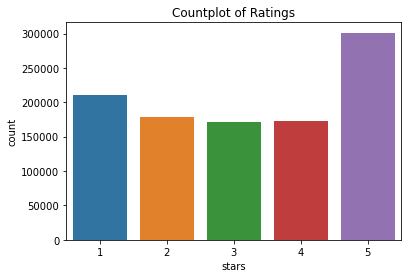

In [9]:
aug_ratings = rev_aug['stars']
plt.title('Countplot of Ratings')
sns.countplot(x=aug_ratings);

In [10]:
rev_aug

,text,stars
0,Total bill for this horrible service? Over $8G...,1
1,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,I have to say that this office really has it t...,5
3,Went in for a lunch. Steak sandwich was delici...,5
4,Today was my second out of three sessions I ha...,1
...,...,...
1034060,"Friendly, courteous and professional! They alw...",5
1034061,Three of my children have hang Kiddie Academy ...,5
1034062,Lived here for 6 months and just late discover...,5
1034063,"I think they ' re so lovely, warm, and accommo...",5


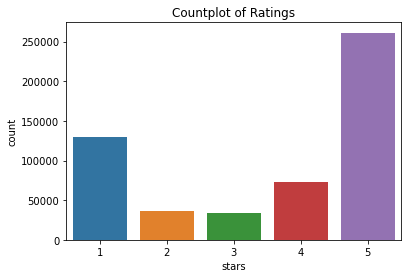

In [11]:
all_ratings = rev['stars']
plt.title('Countplot of Ratings')
sns.countplot(x=all_ratings);

In [12]:
def clean_text(text_data):
    text_data = text_data.lower()
    #text_data = re.sub('\w*\d\w*', "", text_data)
    return text_data   
rev_aug['clean_text'] = rev_aug.text.apply(lambda x: clean_text(x))


In [13]:
inds = np.random.randint(0, rev_aug.shape[0], size = 533581)
X = rev_aug['clean_text'].iloc[inds]
y = rev_aug['stars'].iloc[inds]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.4, random_state=123)

In [15]:
X_train

1006143    i five bought nine west boots about six years ...
473177     i come here whenever i'm visiting my in-laws. ...
491246     this office is so nice and helpful! they are v...
1011899    i would probably say that i ' ve been on a lif...
358627     great personalized service and even had sample...
                                 ...                        
853677     this place was alright. very authentic mainlan...
882038     i bought a gift certificate for aj ' s on rest...
910773     just for ' tech. i brought konstantin 2014 yam...
566505     helen both and stephanie dead are right. gave ...
986426     i dropped in on a friday afternoon and it wasn...
Name: clean_text, Length: 480222, dtype: object

### Our data is not evenly split, with more polarizing reviews being the most popular. Postively rated restaurants are rated the highest

### Real BERT

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
class ProcessData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len, labels):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.labels = labels
    
    def __getitem__(self, index):
        review = self.data[index]
        label = self.labels[index]
        return self.tokenizer.encode_plus(review, max_length=self.max_len, padding='max_length', return_attention_mask=True, return_tensors='pt', truncation=True), review, torch.tensor([label-1]).to(torch.long)
    
    def __len__(self):
        review_length = len(self.data)
        return review_length

In [18]:
tokenized_training_data = ProcessData(X_train.to_numpy().tolist(), tokenizer, 150, y_train.to_numpy())
tokenized_validation_data = ProcessData(X_val.to_numpy().tolist(), tokenizer, 150, y_val.to_numpy())
tokenized_test_data = ProcessData(X_test.to_numpy().tolist(), tokenizer, 150, y_test.to_numpy())

In [19]:
#tokenized_training_data[0][0], tokenized_training_data[0][1], tokenized_training_data[0][2]

In [20]:
#Create dataloader
params = {'batch_size': 16,
          'num_workers': 0}
loader_tokenized_training_data = torch.utils.data.DataLoader(tokenized_training_data, **params)
loader_tokenized_validation_data = torch.utils.data.DataLoader(tokenized_validation_data, **params)
loader_tokenized_test_data = torch.utils.data.DataLoader(tokenized_test_data, **params)

### Training BERT model

In [21]:
class TransTCN2(nn.Module):
    def __init__(self, classes, input_size, num_channels, kernel_size=2, dropout=0.3, n=3, hidden_state=768):
        super(TransTCN2, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.drop = nn.Dropout(p=dropout)
        self.finalLinear = nn.Linear(hidden_state, classes)
        self.linear = nn.Linear(hidden_state, 150)
        self.sm = nn.Softmax(dim=1)
        self.n=n
        self.relu = nn.ReLU()

    #(bert -> tcn) * n -> bert -> linear -> softmax
    def forward(self, input_ids, attention_mask):
        output = input_ids
        for i in range(self.n):
            output = self.bert_model(output, attention_mask)
            output = output[1]
            output = output.unsqueeze(dim=1)
           
            output = self.tcn(output).squeeze(dim=1)
            
            output = self.linear(output)
            output = self.relu(output)
            output = output.long()

        output = self.bert_model(output, attention_mask)
        output = output[1]
        result = self.drop(output)
        result = self.finalLinear(output)

        return result


In [22]:
model = TransTCN2(5, 1, [1,1,1], dropout=0.6).to(device)
#model = model.to(device)
#ex = ex.to(device)
#ex['input_ids'] = ex['input_ids'].to(device)
#ex['attention_mask'] = ex['attention_mask'].to(device)
#ex['token_type_ids'] = ex['token_type_ids'].to(device)

In [23]:
#model(ex['input_ids'], ex['attention_mask'])

In [24]:
#ex

In [25]:
#F.softmax(model(ex['input_ids'], ex['attention_mask']), dim=1)

In [26]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=len(loader_tokenized_training_data) * 5)

In [27]:
def training(model, data_loader, size):
    model = model.train()
    losses = []
    training_acc = 0
    for data in tqdm(data_loader):
        batch_ids = data[0]['input_ids']
        batch_ids = batch_ids.flatten().reshape((batch_ids.shape[0], batch_ids.shape[2]))
        batch_masks = data[0]['attention_mask']
        batch_masks = batch_masks.flatten().reshape((batch_masks.shape[0], batch_masks.shape[2]))
        data[2] = data[2].to(device)
       
       
        output = model(batch_ids.to(device), batch_masks.to(device))
        #print(output)
     
        prediction = torch.max(output, 1)[1]
 
        training_loss = criterion(output, torch.flatten(data[2]))
        training_acc += torch.sum(prediction == torch.flatten(data[2]))
   
        losses.append(training_loss.item())
        training_loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return training_acc / size, np.mean(losses)

In [28]:
def evaluate(model, data_loader, size):
    model = model.eval()
    losses = []
    validation_acc = 0
    with torch.no_grad():
        for vdata in tqdm(data_loader):
            vbatch_ids = vdata[0]['input_ids']
            vbatch_ids = vbatch_ids.flatten().reshape((vbatch_ids.shape[0], vbatch_ids.shape[2]))
            vbatch_masks = vdata[0]['attention_mask']
            vbatch_masks = vbatch_masks.flatten().reshape((vbatch_masks.shape[0], vbatch_masks.shape[2]))
            vdata[2] = vdata[2].to(device)
           

            voutput = model(vbatch_ids.to(device), vbatch_masks.to(device))
            vprediction = torch.max(voutput, 1)[1]
            
            vloss = criterion(voutput, torch.flatten(vdata[2]))
            validation_acc += torch.sum(vprediction == torch.flatten(vdata[2]))
            losses.append(vloss.item())
    return validation_acc / size, np.mean(losses)

In [29]:
#len(loader_tokenized_training_data)
#a = next(iter(loader_tokenized_training_data))

In [30]:
PATH = 'C:/Users/Hardeep/Desktop/nlp_proj'

highest_acc = 0
for epoch in trange(5):
    print('Epoch: ' , str(epoch))
    print('==================================')
    training_accuracy, training_loss = training(model,loader_tokenized_training_data,len(X_train) )
    validation_accuracy, validation_loss = evaluate(model, loader_tokenized_validation_data, len(X_val))
    
    print('Training accuracy: ', training_accuracy )
    print('Training loss: ', training_loss)
    print('Validation accuracy: ', validation_accuracy)
    print('Validation loss: ', validation_loss)
    
    torch.save(model.state_dict(), os.path.join(PATH,'epoch'+str(epoch)+'failure_tcn.pth'))
    #torch.save(model.state_dict(),‘mode.pth’, 'C:/Users/Hardeep/Desktop/nlp_proj')
    
    
    
            
        
        
        

Epoch:  0



Training accuracy:  tensor(0.2903, device='cuda:0')
Training loss:  1.5880433343876652
Validation accuracy:  tensor(0.2946, device='cuda:0')
Validation loss:  1.5845847192971125
Epoch:  1



Training accuracy:  tensor(0.2908, device='cuda:0')
Training loss:  1.5868231036117013
Validation accuracy:  tensor(0.2946, device='cuda:0')
Validation loss:  1.583960931936185
Epoch:  2



Training accuracy:  tensor(0.2909, device='cuda:0')
Training loss:  1.5858842722260833
Validation accuracy:  tensor(0.2946, device='cuda:0')
Validation loss:  1.5829530897764847
Epoch:  3



Training accuracy:  tensor(0.2909, device='cuda:0')
Training loss:  1.5849393595025185
Validation accuracy:  tensor(0.2946, device='cuda:0')
Validation loss:  1.582234710648559
Epoch:  4



Training accuracy:  tensor(0.2909, device='cuda:0')
Training loss:  1.5839803414094724
Validation accuracy:  tensor(0.2946, device='cuda:0')
Validation loss:  1.5814751167406982



In [31]:
test_acc, test_loss = evaluate(model, loader_tokenized_test_data, len(X_test))

In [32]:
test_acc, test_loss

(tensor(0.2887, device='cuda:0'), 1.584947824031338)

In [33]:
test_acc, len(np.where(y_test == 5)[0])/len(y_test)

(tensor(0.2887, device='cuda:0'), 0.2886994002998501)